In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

In [221]:
def laplace_errors(y, X_true, likelihood, H, theta_max):
    cov_theta = np.linalg.inv(-H)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(200):
        theta = np.random.multivariate_normal(theta_max, cov_theta)
        X_b = likelihood.inverse(y, theta)
        ax1.plot(X_b, y, lw=.1, color='gray', alpha=.8)
    ax1.plot(X_true, y, 'x', ms=1, color='blue', label='true')
    ax1.plot(likelihood.inverse(y, theta_max), y, lw=1, color='black', label='maximum')
    ax1.legend();

    samples = 1000
    Xarrays = np.zeros((samples, len(y)))
    for i in range(samples):
        theta = np.random.multivariate_normal(theta_max, cov_theta)
        X_b = likelihood.inverse(y, theta)
        Xarrays[i] = X_b
    X_std = Xarrays.T.std(axis=1)
    X_mean = Xarrays.T.mean(axis=1)

    X_b = likelihood.inverse(y, theta_max)
    ax2.plot(X_true, y, 'x', ms=1, label='true')
    ax2.plot(X_b, y, lw=1, color='black', label='maximum')
    ax2.plot(X_mean, y, lw=1, color='yellow', label='mean')
    ax2.fill_betweenx(y, X_mean - 2*X_std, X_mean + 2*X_std, color='gray', alpha=0.1)
    ax2.fill_betweenx(y, X_mean - X_std, X_mean + X_std, color='gray', alpha=0.2)
    ax2.legend();

    plt.suptitle(theta_max, y=.95)
    plt.tight_layout()

In [31]:
def log_cauchy(X, theta=1):
    return np.log(theta/(theta**2 + X**2))

In [230]:
nk = data_at_iteration(samples_g_1, 1000)[0][-500:]
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

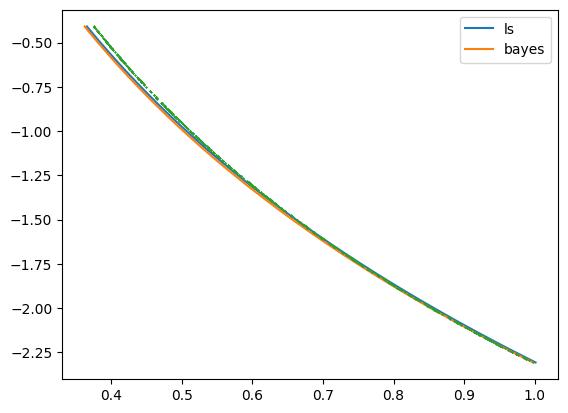

In [231]:
X = generate_Xs(nk)
y = log_cauchy(X, theta=0.1)
theta_l = minimise_ls(y, full, mean_X, [0, 1, 0.1]).x
theta_b = minimise_bayes(y, full, mean_X, covinv_X, theta_l).x
plt.plot(full.inverse(y, theta_l), y, label='ls')
# plt.plot(mean_X, y, label='mean', color='gray', alpha=.4)
plt.plot(full.inverse(y, theta_b), y, label='bayes')
plt.plot(X, y, 'x', ms=1)
# plt.xlim(0.5, 0.7)
# plt.ylim(-1.5, -0.9)
plt.legend();

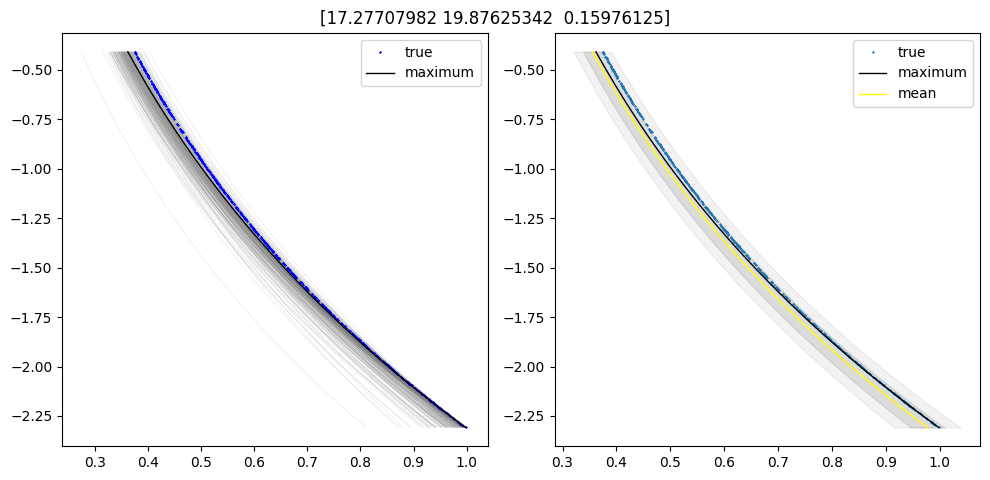

In [243]:
H = hess_autograd(y, full, mean_X, covinv_X, theta_b)
laplace_errors(y, X, full, H, theta_b)